In [16]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import quantumpropagator as qp
from quantumpropagator import readWholeH5toDict, abs2
#from __future__ import print_function
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets

interactive = False

In [17]:
subfolders = sorted([ dir for dir in os.listdir('.') if os.path.isdir(dir) and dir != '.ipynb_checkpoints'])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> aaa_input_FinerGrid_0027
1 -> aaa_input_FinerGrid_0031
2 -> bbb_finerfinergrid_exploding
3 -> bbb_finergrid_3d_withoutpotential
4 -> distort_input_FinerGrid_0000
5 -> distort_input_FinerGrid_0001
6 -> distort_input_FinerGrid_0002
7 -> distort_input_FinerGrid_0003
8 -> distort_input_FinerGrid_0004
9 -> distort_input_FinerGrid_0005
10 -> distort_input_FinerGrid_0006
11 -> distort_input_FinerGrid_0007
12 -> distort_input_FinerGrid_0008
13 -> distort_input_FinerGrid_0009
14 -> distort_input_FinerGrid_0010
15 -> distort_input_FinerGrid_0011
16 -> distort_input_FinerGrid_0012



In [18]:
a = subfolders[-1]
#a = subfolders[1]

In [19]:
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']
outh5 = os.path.join(a,'allInput.h5')
dictio = readWholeH5toDict(outh5)
kind = dictio['kind']
phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
lastV = len(filesList)-1

In [20]:
kind

'Phi'

# 1d slices

In [21]:
filesN = len(filesList)
dime,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape
allwf = np.empty((filesN,dime,nstates),dtype=complex)
alltime = np.empty((filesN))
if kind == 'Phi':
    dim = phis
elif kind == 'Gam':
    dim = gams

In [22]:
for i,fn in enumerate(filesList):
    fnn = os.path.join(a,fn)
    allwf[i] = qp.retrieve_hdf5_data(fnn,'WF')
    alltime[i] = qp.retrieve_hdf5_data(fnn,'Time')[0]
    

In [23]:
def sliceGammas(i):
    wf = allwf[i]
    fig = plt.figure(figsize=(11, 6), dpi= 80, facecolor='w', edgecolor='k')
    ys = wf
    time = alltime[i]
    plt.title('{} - Time = {:10.5f} fs'.format(kind,time))
    plt.ylim(-0.7,0.7)
    plt.plot(dim, np.real(ys), linewidth=1,ls='--')
    plt.plot(dim, np.imag(ys), linewidth=1,ls='--')
    plt.plot(dim, abs2(ys), linewidth=3,ls='-')

def fdim(file_number):
    return sliceGammas(file_number)


initial
final


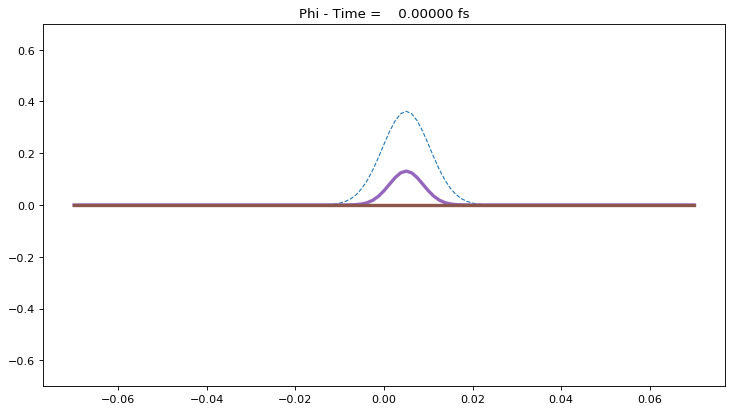

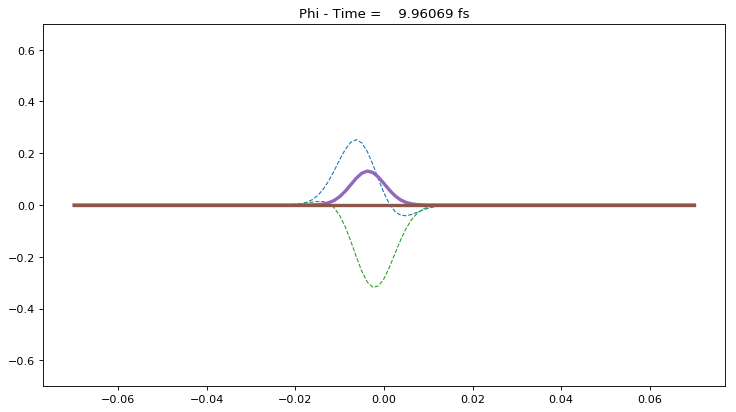

In [24]:
if interactive:
    interact(fdim, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('initial')
    fdim(0)
    print('final')
    fdim(lastV)

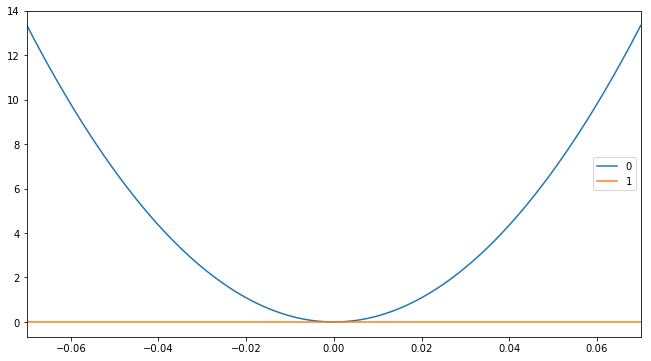

In [25]:
pd.DataFrame(qp.fromHartoEv(dictio['potCube'])).plot(x=dim,figsize=(11, 6));

In [26]:
def kinGam(xder):
    pd.DataFrame(dictio['kinCube'][:,4,xder]).plot(x=dim,figsize=(11, 6))
    
interact(kinGam, xder = widgets.IntSlider(min=0,max=2,step=1,value=0));

interactive(children=(IntSlider(value=0, description='xder', max=2), Output()), _dom_classes=('widget-interact…

In [27]:
outfn = os.path.join(a,'output')
outfnP = os.path.join(a,'outputPopul')
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
dataP = pd.read_csv(outfnP, delim_whitespace=True, header=None);
data.columns = ['steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation','Xpulse','Ypulse','Zpulse']

In [28]:
result = pd.concat([data, dataP], axis=1)
result

,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,Ypulse,Zpulse,0,1,2
0,0,0.000000,1.110223e-16,0.039322,0.107355,0.146677,0.000000e+00,0.0,0.0,0.0,0.0000,1.0,0.0
1,50,0.050050,1.110223e-16,0.039332,0.107345,0.146677,0.000000e+00,0.0,0.0,0.0,0.0500,1.0,0.0
2,100,0.100099,1.110223e-16,0.039361,0.107316,0.146677,4.720426e-17,0.0,0.0,0.0,0.1001,1.0,0.0
3,150,0.150149,1.110223e-16,0.039409,0.107268,0.146677,9.440852e-17,0.0,0.0,0.0,0.1501,1.0,0.0
4,200,0.200199,3.330669e-16,0.039477,0.107200,0.146677,1.652149e-16,0.0,0.0,0.0,0.2002,1.0,0.0
5,250,0.250248,3.330669e-16,0.039564,0.107113,0.146677,9.440852e-17,0.0,0.0,0.0,0.2502,1.0,0.0
6,300,0.300298,2.220446e-16,0.039671,0.107006,0.146677,7.080639e-17,0.0,0.0,0.0,0.3003,1.0,0.0
7,350,0.350347,3.330669e-16,0.039797,0.106880,0.146677,7.080639e-17,0.0,0.0,0.0,0.3503,1.0,0.0
8,400,0.400397,2.220446e-16,0.039942,0.106735,0.146677,1.416128e-16,0.0,0.0,0.0,0.4004,1.0,0.0
9,450,0.450447,1.110223e-16,0.040106,0.106571,0.146677,1.888170e-16,0.0,0.0,0.0,0.4504,1.0,0.0


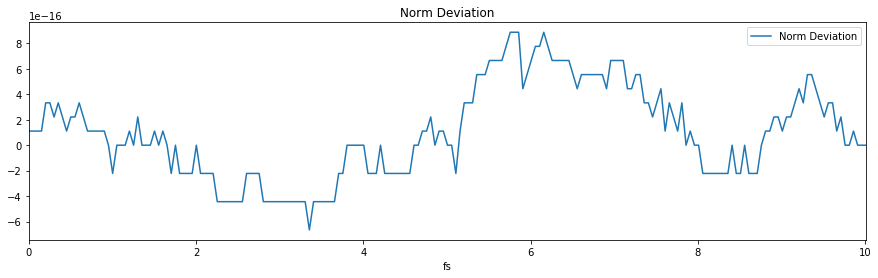

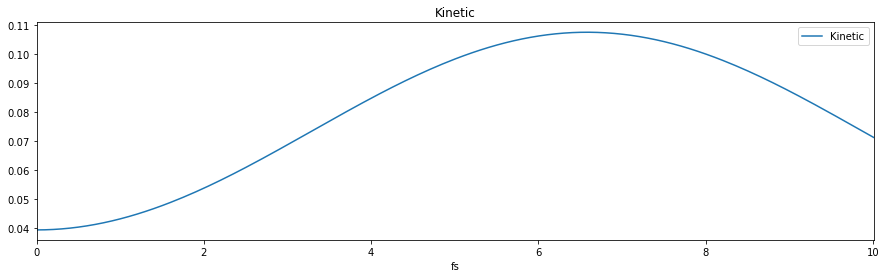

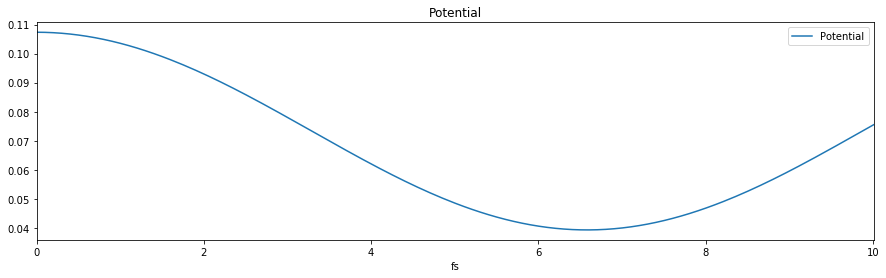

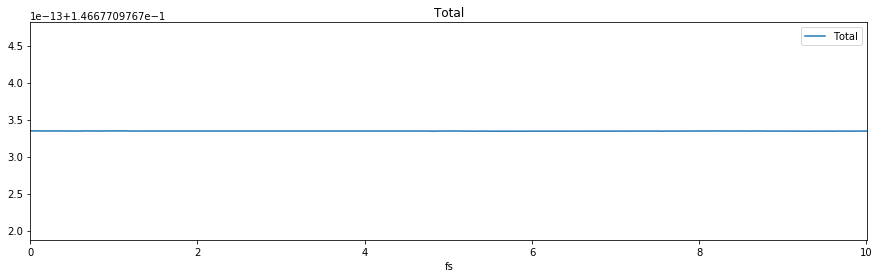

In [29]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4));
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));
data.plot(title = 'Total', x='fs', y = 'Total', figsize=(15,4));

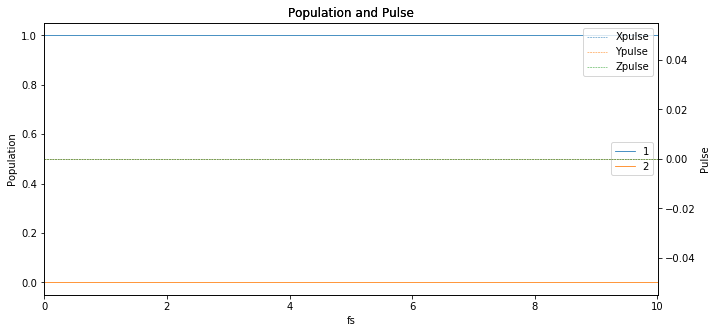

In [30]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_ylabel('Population')
ax2.set_ylabel('Pulse')
popul = np.arange(nstates)+1
result.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'] ,y=popul, linewidth=0.8)
result.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'] ,y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5,ls='--');

## Expected Value

## Borders